In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as la
from scipy import optimize as op
from scipy.stats import norm
from scipy.stats import multivariate_normal
%matplotlib inline

data = pd.read_csv('claim_totals.csv')
data = data.replace({",": ""}, regex = True)
data['Total (including medical only)'] = data['Total (including medical only)'].astype(int)



p = 0, q = 0
Optimization terminated successfully.
         Current function value: 163.829013
         Iterations: 52
         Function evaluations: 102
p = 0, q = 1
Optimization terminated successfully.
         Current function value: 153.873303
         Iterations: 138
         Function evaluations: 249
p = 0, q = 2
Optimization terminated successfully.
         Current function value: 146.648502
         Iterations: 312
         Function evaluations: 529
p = 0, q = 3
Optimization terminated successfully.
         Current function value: 140.233620
         Iterations: 657
         Function evaluations: 1045
p = 1, q = 0
Optimization terminated successfully.
         Current function value: 136.184986
         Iterations: 169
         Function evaluations: 311
p = 1, q = 1
Optimization terminated successfully.
         Current function value: 129.163774
         Iterations: 531
         Function evaluations: 906
p = 1, q = 2
Optimization terminated successfully.
         Current fu

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log


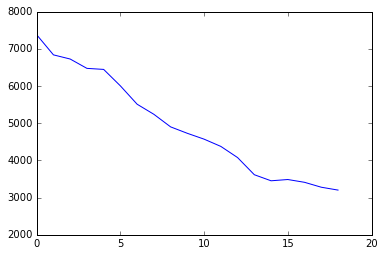

In [3]:
N = norm.pdf
time_series_a = data['Total (including medical only)']

def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0., sigma=1.):
    """
    Return the log-likelihood of the ARMA model parameters, given the time series.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    
    Returns
    -------
    log_likelihood : float
        The log-likelihood of the model
    """
    n = len(time_series)
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    
    # initialize F, H, and Q matrices
    H = np.zeros(r)
    H[0] = 1
    H[1:1+q] = thetas
    
    F = np.diag([1.]*(r-1),-1)
    F[0,:p] = phis
    
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    
    # initialize xhat and P
    xhat = np.zeros(r)
    temp = np.eye(r**2) - np.kron(F,F)
    P = la.solve(temp, Q.flatten()).reshape(r,r)
    
    log_likelihood = 0.
    
    for i in range(n):
        z = time_series[i] - mu
        log_likelihood += np.log(N(time_series[i],
                                   loc=(H.dot(xhat) + mu),
                                   scale=np.sqrt(np.abs(H.dot(P).dot(H.T)))))
        
        w = multivariate_normal.rvs(cov=Q)
        
        # update step
        y = z - H.dot(xhat)
        S = H.dot(P).dot(H.T) # + R? (observation error)
        K = P.dot(H.T)/S # S should be a scalar
        xhat += K.dot(y)
        P = np.dot(np.eye(r) - np.outer(K,H), P)
        
        xhat = F.dot(xhat)# + w
        P = F.dot(P).dot(F.T) + Q
        
        
    return log_likelihood




def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    
    Returns
    -------
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    """
    n = len(time_series)
    
    best_AIC = np.inf # lowest = best
    best_params = 0 # parameters
    best_p = 0
    best_q = 0
    
    for p in range(0,4):
        for q in range(0,4):
            print 'p = %i, q = %i' % (p,q)
            k = p + q + 2
            
            def f(x): # negative log likelihood
                return -arma_likelihood(time_series, phis = x[:p], thetas=x[p:p+q],
                                        mu=x[-2], sigma=x[-1])
            x0 = np.zeros(p+q+2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = op.fmin(f, x0, maxiter=10000, maxfun=10000)
            
            AIC = 2*f(sol) + 2*k*(1 + (k+1)/float(n-k))
            
            if AIC < best_AIC:
                best_AIC = AIC
                best_params = sol
                best_p = p
                best_q = q
                
    print 'Best AIC:', best_AIC
    return (best_params[:best_p], best_params[best_p:best_p+best_q],
            best_params[-2], best_params[-1])




phis_a1, thetas_a1, mu_a1, sigma_a1 = arma_fit(time_series_a)
print 'p =', len(phis_a1)
print 'q =', len(thetas_a1)
print 'phis:', phis_a1
print 'thetas:', thetas_a1
print 'mu:', mu_a1
print 'sigma:', sigma_a1



def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0., sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    future_periods : int
        The number of future periods to return
    
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
        The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
        The standard deviations of z for times n+1, ..., n+future_periods
    """
    n = len(time_series)
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    
    # initialize F, H, and Q matrices
    H = np.zeros(r)
    H[0] = 1
    H[1:1+q] = thetas
    
    F = np.diag([1.]*(r-1),-1)
    F[0,:p] = phis
    
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    
    # initialize xhat and P
    xhat = np.zeros(r)
    temp = np.eye(r**2) - np.kron(F,F)
    P = la.solve(temp, Q.flatten()).reshape(r,r)
    
    for i in range(n):
        z = time_series[i] - mu
        
        # update step
        y = z - H.dot(xhat)
        S = H.dot(P).dot(H.T) # + R? (observation error)
        K = P.dot(H.T)/S # S should be a scalar
        xhat += K.dot(y)
        P = np.dot(np.eye(r) - np.outer(K,H), P)
        
        if i == n-1:
            break
        
        # predict step
        xhat = F.dot(xhat)
        P = F.dot(P).dot(F.T) + Q
    
    e_vals = []
    sigs = []
    for i in range(future_periods):
        xhat = F.dot(xhat)
        P = F.dot(P).dot(F.T) + Q
        
        e_vals.append(H.dot(xhat) + mu)
        sigs.append(np.sqrt(H.dot(P).dot(H.T)))
    
        
    return np.array(e_vals), np.array(sigs)






n = len(time_series_a)
e_vals1, sigs1 = arma_forecast(time_series_a, phis_a1, thetas_a1, mu_a1, sigma_a1, 1)
plt.plot(time_series_a)
plt.plot(range(n,n+1), e_vals1)
plt.plot(range(n,n+1), e_vals1 + sigs1, ls='-')
plt.plot(range(n,n+1), e_vals1 - sigs1, ls='-')
plt.plot(range(n,n+1), e_vals1 + 2*sigs1, ls='-')
plt.plot(range(n,n+1), e_vals1 - 2*sigs1, ls='-')
plt.show()


In [4]:
np.savetxt('claims_projected', e_vals1)
np.savetxt('claims_projected_sig', sigs1)


